In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math

# Load the data and manually override false positives

In [2]:
with open('hindi_hits_from_1947_to_2022_ai_enhanced.json', 'r') as f:
    lines = set(f.readlines())
movies = json.loads("[" + ",".join(lines) + "]")
print("Loaded {} movies".format(len(movies)))

Loaded 740 movies


In [3]:
# a given gender's score is proportional to two factors:
# 1) how many actors of that gender there are
# 2) how high up in the cast list they are
def female_cast_importance(cast):
    score = {'male': 0, 'female': 0}
    
    for i, actor in enumerate(cast):
        gender = actor['gender'].lower()
        if gender in ['male', 'female']:
            score[gender] += 1 / math.log(i+2)  # Higher weight for actors earlier in the list
        
    return score['female'] / (score['male'] + score['female'])

ex = female_cast_importance([{'gender': 'male'}, {'gender': 'male'}, {'gender': 'male'}, {'gender': 'female'}])
print("female-cast-importance if the cast is 'male, male, male, female' is {}".format(ex))

female-cast-importance if the cast is 'male, male, male, female' is 0.16812753627111746


In [4]:
rows = []
for movie in movies:
    if movie['title'] == "Roti":
        # this one's broken
        continue
    cast_string = ", ".join([x['name'] for x in movie['cast'][:4]])
    # put all of these into a pandas dataframe
    rows.append({
        'year': movie['year'],
        'title_link': '<a href="' + movie['movie_url'] + '">' + movie['title'] + '</a>',
        'title': movie['title'],
        'female-led': movie['female-led'],
        'female_cast_importance': female_cast_importance(movie['cast']),
        'female_director': movie['director']['gender'].lower() == "female",
        'director_name': movie['director']['name'],
        'actors': cast_string
    })
df = pd.DataFrame(rows)

In [5]:
# Manually override some movies that were incorrectly classified
female_led_false_positives = [
    "Mujhse Dosti Karoge!",
    "Pardes",
    "Anari",
    "Amrit",
    "Judaai",
    "Tum Haseen Main Jawan",
    "Sharafat",
    "Aya Sawan Jhoom Ke",
    "An Evening in Paris",
    "Phool Aur Patthar",
    "Guide",
    "Gehra Daag",
    "Dil Apna Aur Preet Parayi",
    "Phagun",
    "Phir Subah Hogi",
    "Jagriti",
    "Sangdil",
    "Jadoo",
    "Arzoo",
    "Saathiya",
    "Ready",
    "Goliyon Ki Raasleela Ram-Leela",
    "Badrinath Ki Dulhania"
]
df.loc[df['title'].isin(female_led_false_positives), 'female-led'] = False

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

# List of movies considered 'female-led'

In [7]:
# female led, sort by year
subset = df[df["female-led"]==True].sort_values(by="year")
display(HTML(subset.to_html(index=False, escape=False)))

year,title_link,title,female-led,female_cast_importance,female_director,director_name,actors
1947,Mirza Sahiban,Mirza Sahiban,True,0.61,False,K. Amarnath,"Nurjehan, Trilok Kapoor"
1947,Neel Kamal,Neel Kamal,True,0.70,False,Kidar Sharma,"Begum Para, Raj Kapoor, Madhubala"
1949,Singaar,Singaar,True,0.77,False,J. K. Nanda,"Suraiya, Madhubala, Jairaj"
1949,Bari Behen,Bari Behen,True,0.49,False,D. D. Kashyap,"Suraiya, Rehman, Ullhas, Geeta Bali"
1950,Beqasoor,Beqasoor,True,0.39,False,K. Amarnath,"Madhubala, Ajit, Yakub, Gope"
1951,Hum Log,Hum Log,True,0.75,False,Zia Sarhadi,"Nutan, Balraj Sahni, Shyama, Durga Khote"
1952,Anhonee,Anhonee,True,0.39,False,K. A. Abbas,"Raj Kapoor, Nargis"
1953,Parineeta,Parineeta,True,0.39,False,Bimal Roy,"Ashok Kumar, Meena Kumari"
1957,Mother India,Mother India,True,0.39,False,Mehboob Khan,"Nargis, Sunil Dutt, Rajendra Kumar, Raaj Kumar"
1958,Sadhna,Sadhna,True,0.31,False,B.R. Chopra,"Sunil Dutt, Vyjayanthimala, Leela Chitnis, Radhakrishan"


# List of movies with female directors

In [8]:
subset = df[df["female_director"]][["year", "title_link", "director_name", "actors", "female-led", "female_cast_importance"]]
display(HTML(subset.to_html(escape=False)))

,year,title_link,director_name,actors,female-led,female_cast_importance
12,2019,Gully Boy,Zoya Akhtar,"Ranveer Singh, Alia Bhatt, Siddhant Chaturvedi",False,0.30
20,2014,Happy New Year,Farah Khan,"Deepika Padukone, Shah Rukh Khan, Abhishek Bachchan, Sonu Sood",False,0.27
197,2012,Talaash: The Answer Lies Within,Reema Kagti,"Aamir Khan, Kareena Kapoor, Rani Mukerji, Nawazuddin Siddiqui",False,0.45
368,2020,Panga,Ashwiny Iyer Tiwari,"Kangana Ranaut, Jassi Gill, Yagya Bhasin, Richa Chadda",True,0.62
456,2020,Chhapaak,Meghna Gulzar,"Deepika Padukone, Vikrant Massey",True,0.61
473,2015,Dil Dhadakne Do,Zoya Akhtar,"Anil Kapoor, Shefali Shah, Priyanka Chopra, Ranveer Singh",False,0.46
517,2010,Tees Maar Khan,Farah Khan,"Akshay Kumar, Akshaye Khanna, Katrina Kaif",False,0.23
541,2011,Zindagi Na Milegi Dobara,Zoya Akhtar,"Hrithik Roshan, Abhay Deol, Farhan Akhtar, Katrina Kaif",False,0.28
559,2007,Om Shanti Om,Farah Khan,"Shah Rukh Khan, Deepika Padukone, Shreyas Talpade, Kirron Kher",False,0.36
668,2004,Main Hoon Na,Farah Khan,"Shah Rukh Khan, Sushmita Sen, Sunil Shetty, Amrita Rao",False,0.36


# List of movies with female_cast_importance > 0.6

In [9]:
subset = df[df["female_cast_importance"] >= 0.6]
# Select specific columns
subset = subset[["year", "title_link", "director_name", "actors", "female_cast_importance"]]
subset = subset.sort_values(by="female_cast_importance", ascending=False)
display(HTML(subset.to_html(escape=False)))

,year,title_link,director_name,actors,female_cast_importance
279,2020,Thappad,Anubhav Sinha,Taapsee Pannu,1.00
522,2018,Hichki,Siddharth P. Malhotra,Rani Mukerji,1.00
173,1947,Dard,Abdul Rashid Kardar,"Munawwar Sultana, Suraiya, Nusrat, Husn Banu",0.80
730,1949,Singaar,J. K. Nanda,"Suraiya, Madhubala, Jairaj",0.77
372,1951,Hum Log,Zia Sarhadi,"Nutan, Balraj Sahni, Shyama, Durga Khote",0.75
289,2001,Lajja,Rajkumar Santoshi,"Manisha Koirala, Rekha, Madhuri Dixit, Mahima Chaudhry",0.70
699,2000,Fiza,Khalid Mohammed,"Karisma Kapoor, Hrithik Roshan, Jaya Bachchan",0.70
377,1947,Neel Kamal,Kidar Sharma,"Begum Para, Raj Kapoor, Madhubala",0.70
297,1955,Mr. & Mrs. '55,Guru Dutt,"Madhubala, Guru Dutt, Lalita Pawar",0.70
18,1959,Sujata,Bimal Roy,"Nutan, Sunil Dutt, Shashikala",0.70


# Plotting all three measures together, over time. 

In [10]:
#import os
#os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
#plt.style.use(['science'])
#plt.style.use('default')



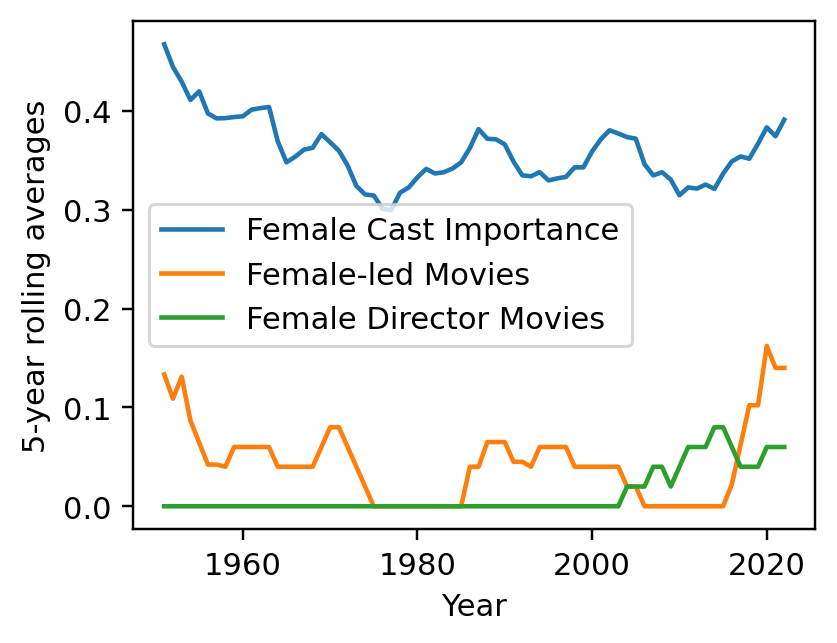

In [11]:
cast_importance = df.groupby('year')['female_cast_importance'].mean().rolling(window=5).mean()
female_led = df.groupby('year')['female-led'].mean().rolling(window=5).mean()
female_director = df.groupby('year')['female_director'].mean().rolling(window=5).mean()

desired_dpi = 220
fig_width, fig_height = 4, 3

plt.figure(figsize=(fig_width, fig_height), dpi=desired_dpi)
# Plot each series
plt.plot(cast_importance, label='Female Cast Importance')
plt.plot(female_led, label='Female-led Movies')
plt.plot(female_director, label='Female Director Movies')

# Set plot title and labels
#plt.title('Evolution of Female Representation in Movies')
plt.xlabel('Year')
plt.ylabel('5-year rolling averages')

# Show the legend
plt.legend()

# Display the plot
plt.show()
